In [1]:
import pandas as pd
import numpy as np
from datasets import load_abundance_data, load_markers_data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()
sns.set(font_scale = 1.5)

In [3]:
#load data
dfs=load_abundance_data()
markers=load_markers_data()

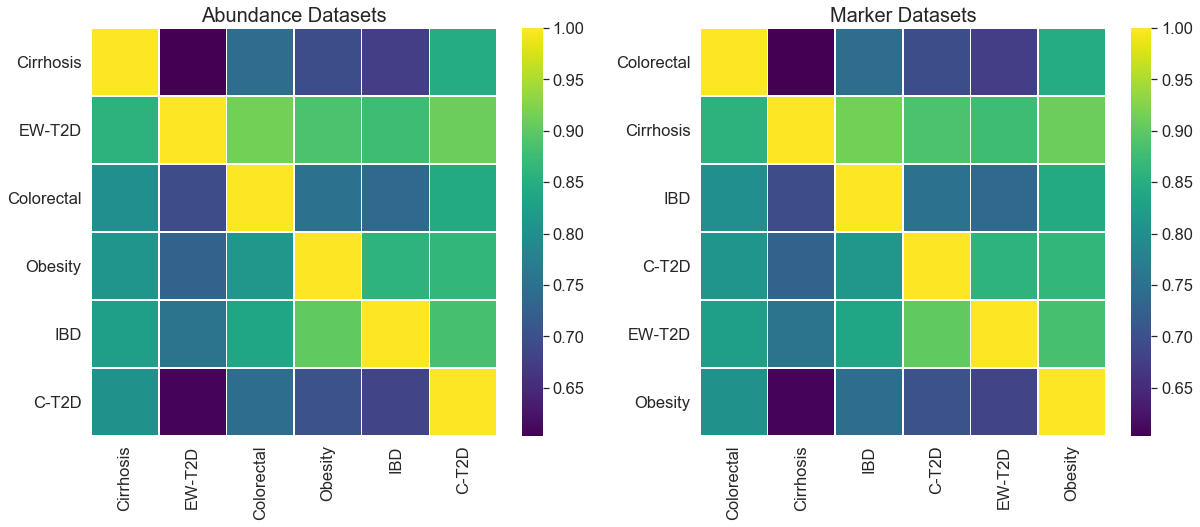

In [127]:
#exploring overlap between datasets
cols = []
[cols.append( df.columns[df.columns.str.contains('k__')] ) for df in dfs]
abundance_overlaps=np.zeros((len(cols), len(cols)))
for i in range(len(cols)):
    for j in range(0, len(cols)):
            abundance_overlaps[i,j]=(sum(cols[i].isin(cols[j]))/cols[i].shape[0])
  
fig, axis = plt.subplots(1, 2, figsize = (20, 7.5)) 
            
ax = sns.heatmap(abundance_overlaps, 
                 linewidth=0.5,
                 yticklabels=['Cirrhosis','EW-T2D','Colorectal', 'Obesity','IBD', 'C-T2D'],
                 xticklabels=['Cirrhosis','EW-T2D','Colorectal', 'Obesity','IBD', 'C-T2D'], 
                 cmap='viridis', 
                 ax=axis[0])
axis[0].set_title('Abundance Datasets', size=20)


marker_cols = []
[marker_cols.append( df.columns[df.columns.str.contains('gi[|]')] ) for df in markers]
abundance_overlaps=np.zeros((len(cols), len(cols)))
for i in range(len(cols)):
    for j in range(0, len(cols)):
            abundance_overlaps[i,j]=(sum(cols[i].isin(cols[j]))/cols[i].shape[0])
            
            
ax = sns.heatmap(abundance_overlaps, 
                 linewidth=0.5,
                 yticklabels=['Colorectal','Cirrhosis','IBD','C-T2D','EW-T2D','Obesity'],
                 xticklabels=['Colorectal','Cirrhosis','IBD','C-T2D','EW-T2D','Obesity'], 
                 cmap='viridis', 
                 ax=axis[1])
axis[1].set_title('Marker Datasets', size=20)
#plt.suptitle('Exploring Taxa Overlap Across Datasets')

plt.savefig('figures/overlap_heatmap.png')
plt.show()



In [5]:
disease_map=pd.DataFrame( ['Zeller_fecal_colorectal_cancer',
                         'Quin_gut_liver_cirrhosis',
                         'metahit',
                         't2dmeta_long',
                         'WT2D',
                         'Chatelier_gut_obesity', 
                          't2dmeta_short'], 
             ['Colorectal', 'Cirrhosis', 'IBD', 'C-T2D', 'EW-T2D', 'Obesity', 'C-T2D'] 
            ).reset_index()

disease_map.columns = ['clean', 'raw']

In [6]:
all_dfs = pd.concat( [dfs[i][cols[i]].astype(float) for i in range(len(dfs))], axis = 1).fillna(0)
all_dfs = all_dfs.T.groupby('dataset_name').sum().T
all_dfs['dataset'] = all_dfs.index.str.split('.').str[0]
all_dfs = all_dfs[['dataset']+list(all_dfs.columns[:-1])]
all_dfs = all_dfs.reset_index(drop=True)
all_dfs = all_dfs.fillna(0)
all_dfs=disease_map.merge(all_dfs, left_on='raw', right_on='dataset').drop(['raw', 'dataset'], axis=1)
all_dfs.columns=['dataset'] + list(all_dfs.columns[1:])

In [7]:
from sklearn.decomposition import PCA

In [8]:
qq = all_dfs.loc[all_dfs.dataset.isin(['Zeller_fecal_colorectal_cancer', 'Chatelier_gut_obesity'])]

In [9]:
all_dfs.dataset.unique()

array(['Colorectal', 'Cirrhosis', 'IBD', 'C-T2D', 'EW-T2D', 'Obesity'],
      dtype=object)

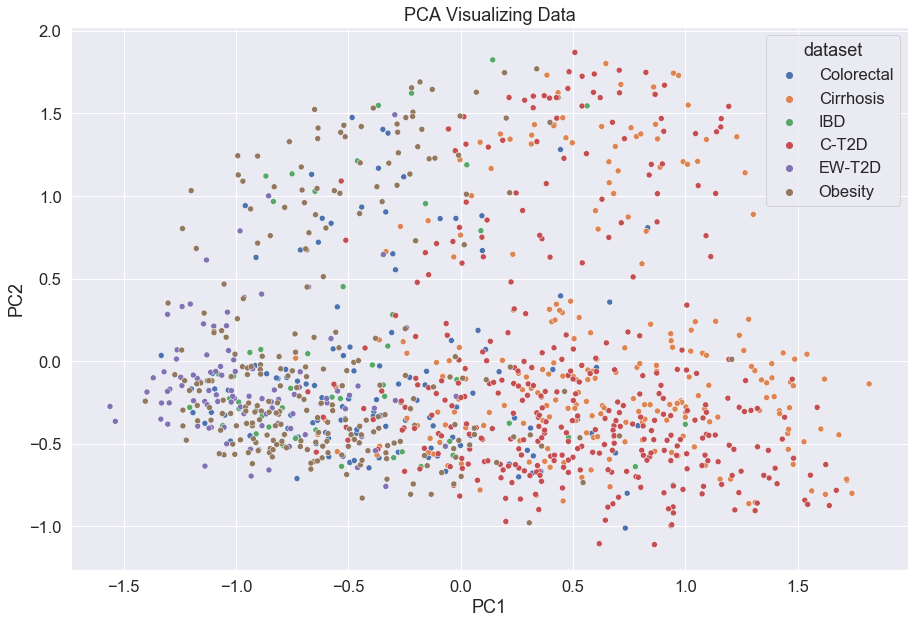

In [126]:
pc = PCA(n_components = 2)
plt.figure(figsize = (15,10))
x = pc.fit_transform( np.log10(1 + all_dfs.iloc[:, 1:].values) )
sns.scatterplot(x = x[:, 0], y = x[:, 1], hue = all_dfs['dataset'], alpha = 1)#.str.upper().str.strip())
plt.title('PCA Visualizing Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim([-0.025, 0.001])
plt.savefig('figures/abundance_pca.png')
plt.show()

In [45]:
%config Completer.use_jedi = False

In [47]:
pc.components_.

(2, 771)

Generally speaking, we do see some separation across datasets, with the Obesity and EW-T2D PCs centering towards the bottom left, and the C-T2D and Cirrhosis Data skewing towards the positive PC1 area. On the plus side, every dataset's PCA representation is similar to those from at least one other study, so there is opportunity to test the transfer learning as is. 

In [11]:
from skbio.stats.ordination import pcoa
from  scipy.spatial.distance import braycurtis as bc
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('pyfunc', func = bc)

def make_pcoa(df):
    mat = df.iloc[:, 1:].values
    mat = (mat / mat.sum(axis = 1)[:, np.newaxis] )
    dist = DistanceMetric.get_metric('pyfunc', func = bc)
    log_mat = np.log10(np.array( 1 + mat, dtype = np.float64))
    distances = dist.pairwise(log_mat)
    pcoa_result = pcoa( distances )
    return(pcoa_result)

In [59]:
dfs[2].disease.value_counts()

cancer           48
n                47
small_adenoma    26
Name: disease, dtype: int64

identifying where each dataset is coming from (all are fecal gut samples). (All data were processed in same way in the DeepMicro approach):
- IBD: European Adults, 2010
- EWT2D: European Women, 2013
- CT2D: Chinese Individuals, 2012
- Obesity: Danish, 2013
- Cirrhosis: Chinese Patients, 2014
- CRC: France, 2014

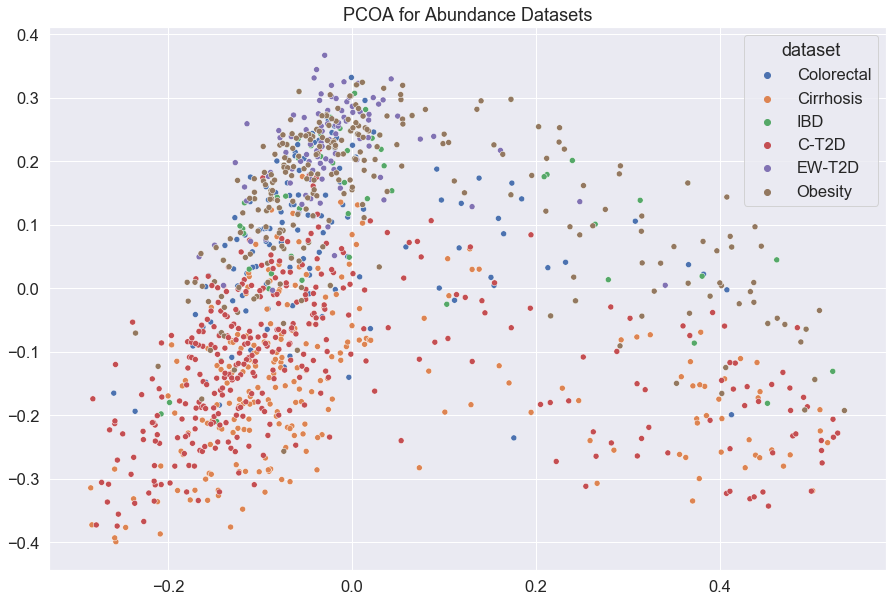

In [124]:
all_pcoas=make_pcoa(all_dfs)
plt.figure(figsize = (15, 10))
sns.scatterplot(x = all_pcoas.samples.PC1.values, 
                y = all_pcoas.samples.PC2.values, 
                hue = all_dfs.dataset.astype(str)
               )
plt.title("PCOA for Abundance Datasets")
plt.savefig('figures/abundance_pcoa.png')
plt.show()

In [ ]:
all_pcoas=make_pcoa(all_dfs)
plt.figure(figsize = (15, 10))
sns.scatterplot(x = all_pcoas.samples.PC1.values, 
                y = all_pcoas.samples.PC2.values, 
                hue = all_dfs.dataset.astype(str)
               )
plt.title("PCOA for Abundance Datasets")
plt.show()

In [87]:
[a.index[0] for a in dfs]

['Quin_gut_liver_cirrhosis',
 'WT2D',
 'Zeller_fecal_colorectal_cancer',
 'Chatelier_gut_obesity',
 'metahit',
 't2dmeta_long']

In [88]:
48+26

74

In [86]:

[a.disease.value_counts() for a in dfs]

[cirrhosis    118
 n            114
 Name: disease, dtype: int64,
 t2d    53
 n      43
 Name: disease, dtype: int64,
 cancer           48
 n                47
 small_adenoma    26
 Name: disease, dtype: int64,
 obesity    164
 leaness     89
 Name: disease, dtype: int64,
 n                         85
 ibd_ulcerative_colitis    21
 ibd_crohn_disease          4
 Name: disease, dtype: int64,
 n      174
 t2d    170
 Name: disease, dtype: int64]

In [69]:
all_markers = pd.concat( [markers[i][marker_cols[i]].astype(float) for i in range(len(markers))], axis = 1).fillna(0)
all_markers = all_markers.T.groupby('dataset_name').sum().T
all_markers['dataset'] = all_markers.index.str.split('.').str[0]
all_markers = all_markers[['dataset']+list(all_markers.columns[:-1])]
all_markers = all_markers.reset_index(drop=True)
all_markers = all_markers.fillna(0)
all_markers=disease_map.merge(all_markers, left_on='raw', right_on='dataset').drop(['raw', 'dataset'], axis=1)
all_markers.columns=['dataset'] + list(all_markers.columns[1:])

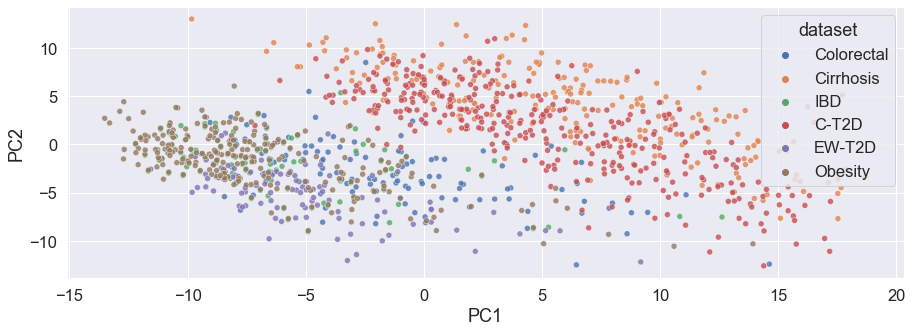

In [129]:
pc = PCA(n_components = 2)
plt.figure(figsize = (15,5))
#x = pc.fit_transform( np.log10(1 + all_markers.iloc[:, 1:].values) )
sns.scatterplot(x = x[:, 0], y = x[:, 1], hue = all_markers['dataset'], alpha = 0.8)#.str.upper().str.strip())
#plt.title('PCA Visualizing Markers Datasets')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('figures/markers_pca.png')
plt.show()

In [122]:
all_markers.shape

(1156, 168154)

In [117]:
import os
os.listdir()

['EDA.ipynb',
 'checkpoint_dir',
 '.DS_Store',
 'gia2105_ML4FG_Proposal.pdf',
 'rf_summary.csv',
 'sae_summary.csv',
 'Run_Baseline_Models.ipynb',
 'datasets.py',
 'svm_summary.csv',
 'ffnn_summary.csv',
 '__pycache__',
 'dae_summary.csv',
 'results',
 'training_functions.py',
 '.gitignore',
 'vae_summary.csv',
 'pytorch_models.py',
 'figures',
 'Make_Result_Plots.ipynb',
 '.ipynb_checkpoints',
 '.git',
 'data']

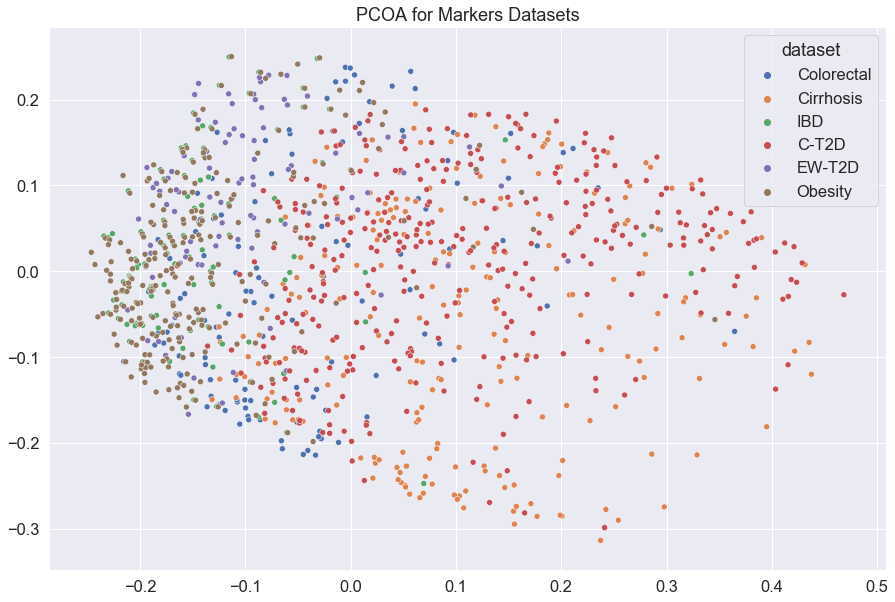

In [119]:
all_pcoas=make_pcoa(all_markers)
plt.figure(figsize = (15, 10))
sns.scatterplot(x = all_pcoas.samples.PC1.values, 
                y = all_pcoas.samples.PC2.values, 
                hue = all_markers.dataset.astype(str)
               )
plt.title("PCOA for Markers Datasets")
plt.savefig('marker_pcoa.png')
plt.show()

## Good news! It doesn't seem like we have severe batch effects, at least based on the PCA plot

In [113]:
descriptions=pd.DataFrame({
            'IBD': ('European', 2010, 25, 85),
            'EW-T2D': ('European Women', 2013, 53, 43),
            'C-T2D': ('Chinese' , 2012, 170, 174),
            'Obesity': ('Danish', 2013, 164, 89),
            'Cirrhosis': ('Chinese', 2014,  118, 114),
            'Colorectal': ('French', 2014, 74, 47)
            })
descriptions=descriptions.T
descriptions.columns=['Nationality', 'Year', 'Positive Samples', 'Negative Controls']
descriptions

,Nationality,Year,Positive Samples,Negative Controls
IBD,European,2010,25,85
EW-T2D,European Women,2013,53,43
C-T2D,Chinese,2012,170,174
Obesity,Danish,2013,164,89
Cirrhosis,Chinese,2014,118,114
Colorectal,French,2014,74,47
